In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
batchSize=32
imgSize=256
rgbChannels=3
EPOCHS=75

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    r"../PlantDiseasesDataset/active",
    seed=128,
    shuffle=True,
    image_size=(imgSize,imgSize),
    batch_size=batchSize
)

Found 5822 files belonging to 2 classes.


In [4]:
classes=dataset.class_names
classes

['0Grape Healthy', 'Grape Isariopsis Leaf Spot']

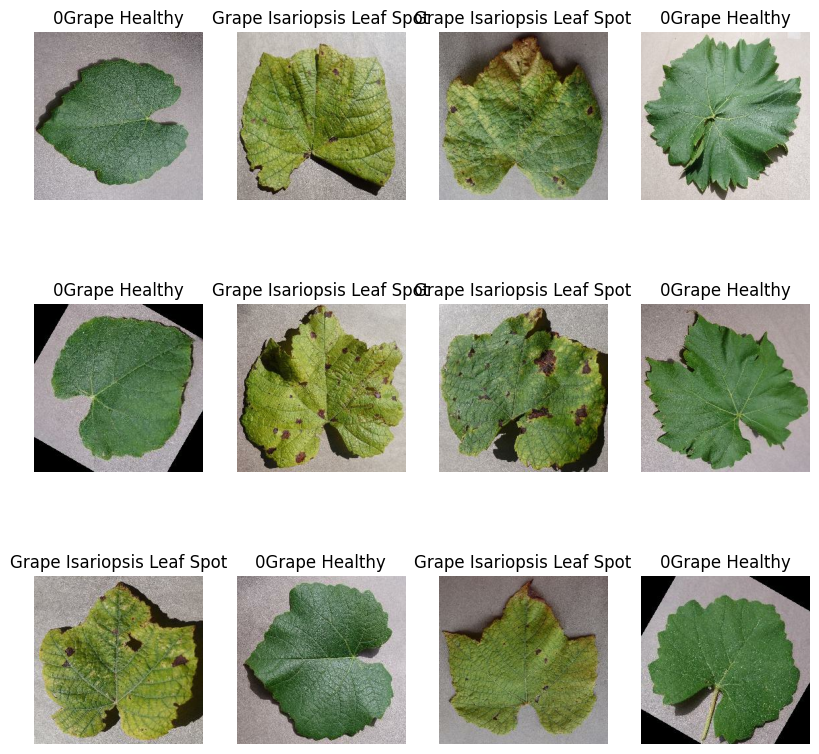

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])
    plt.axis("off")

In [6]:
def getSplittedDataset(ds, trainSplit=0.8, testSplit=0.1, valSplit=0.1, shuffle=True, shuffleSize=10000):
  assert (trainSplit + testSplit + valSplit) ==1
  dsSize = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffleSize, seed=12)
  trainSize = int(trainSplit * dsSize)
  testSize = int(testSplit * dsSize)
  trainDataset = ds.take(trainSize)
  testDataset = ds.skip(trainSize).take(testSize)
  valDataset = ds.skip(trainSize).skip(testSize)
  return trainDataset, testDataset, valDataset

In [7]:
trainDataset, testDataset, valDataset = getSplittedDataset(dataset)

In [8]:
len(dataset)

182

In [9]:
trainDataset= trainDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset= testDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valDataset= valDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
dataAugmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [11]:
resizeRescale = tf.keras.Sequential([
    layers.Resizing(imgSize, imgSize),
    layers.Rescaling(1.0/255)
])

In [12]:
trainDataset = trainDataset.map(
    lambda x, y: (dataAugmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
inputShape = (batchSize, imgSize, imgSize, rgbChannels)

model = models.Sequential([
    resizeRescale,
    layers.Conv2D(64, (1,1), activation='relu', input_shape=inputShape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.build(input_shape= inputShape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 64)        256       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 128, 128, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 127, 127, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 63, 63, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 61, 61, 64)         

In [14]:
early_stop= tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3, verbose=1)

In [15]:
model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

In [16]:
model.fit(trainDataset, validation_data= valDataset, epochs= EPOCHS, callbacks= [early_stop])

Epoch 1/75
145/145 [==============================] - 68s 341ms/step - loss: 0.2423 - accuracy: 0.9013 - val_loss: 0.1113 - val_accuracy: 0.9605
Epoch 2/75
145/145 [==============================] - 30s 208ms/step - loss: 0.0738 - accuracy: 0.9774 - val_loss: 0.0506 - val_accuracy: 0.9901
Epoch 3/75
145/145 [==============================] - 31s 216ms/step - loss: 0.0464 - accuracy: 0.9862 - val_loss: 0.0517 - val_accuracy: 0.9819
Epoch 4/75
145/145 [==============================] - 31s 216ms/step - loss: 0.0359 - accuracy: 0.9888 - val_loss: 0.0451 - val_accuracy: 0.9868
Epoch 5/75
145/145 [==============================] - 31s 216ms/step - loss: 0.0284 - accuracy: 0.9901 - val_loss: 0.0276 - val_accuracy: 0.9951
Epoch 6/75
145/145 [==============================] - 31s 215ms/step - loss: 0.0298 - accuracy: 0.9920 - val_loss: 0.0438 - val_accuracy: 0.9868
Epoch 7/75
145/145 [==============================] - 32s 221ms/step - loss: 0.0220 - accuracy: 0.9933 - val_loss: 0.0245 - val_ac

In [17]:
score= model.evaluate(valDataset.take(1))

1/1 [==============================] - 0s 126ms/step - loss: 0.0023 - accuracy: 1.0000


NameError: name 'predFunc' is not defined

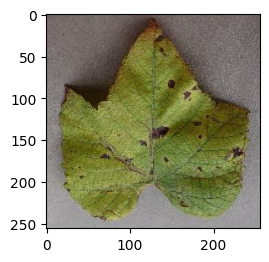

In [18]:
plt.figure(figsize= (16, 24))

for images, labels in valDataset.take(1):
    for i in range(15):
        ax= plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predictedCls, confidence= predFunc(model, images[i].numpy())
        actualCls= clsNames[labels[i]]

        plt.title(f"Actual label: {actualCls} \n Predicted Label: {predictedCls} \n Confidence score: {confidence}%")
        plt.axis('off')

In [ ]:
acc= history.history['accuracy']
valAccuracy= history.history['val_accuracy']

loss= history.history['loss']
valLoss= history.history['val_loss']

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
       tf.lite.OpsSet.TFLITE_BUILTINS,
       tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

with open('../exports/grape_isariopsis_leaf_spot.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpzue4ni7w\assets


INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpzue4ni7w\assets
